##Import e style

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(COLORS))
rcParams['figure.figsize'] = 12, 8
#####

RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()#Rende visibili le modifiche

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cpu')

## Importa dataset



In [ ]:
!rm -rf GTSRB
!rm -rf data
!rm -rd GTSRB_Final_Training_Images.zip

rm: cannot remove 'GTSRB_Final_Training_Images.zip': No such file or directory


In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-19 15:57:16--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  25.6MB/s    in 11s     

2022-07-19 15:57:27 (23.7 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration 


In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
print("Classi:")                                              #senza sorted altera ordine delle classi
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [ ]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


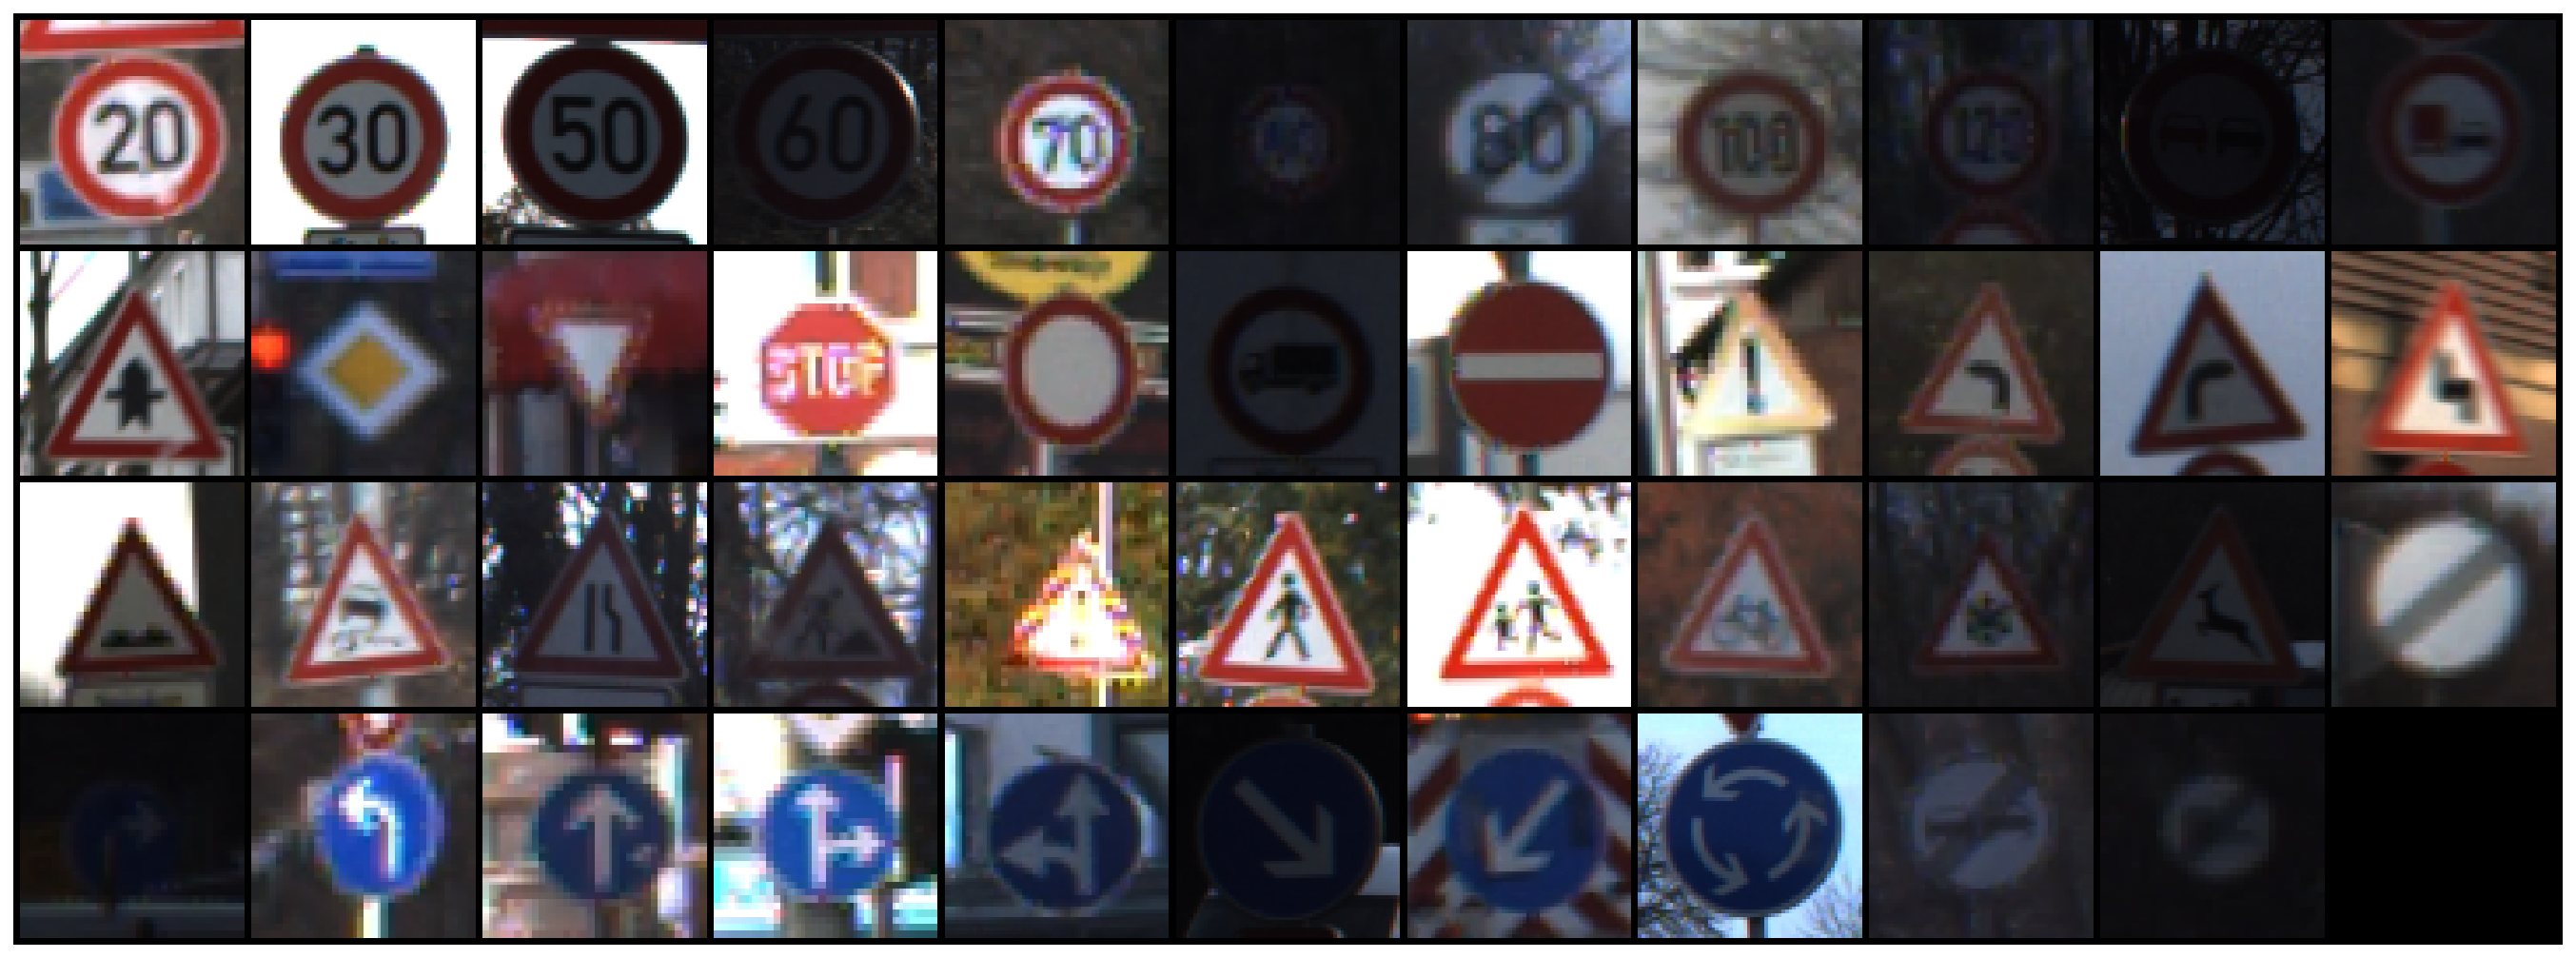

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

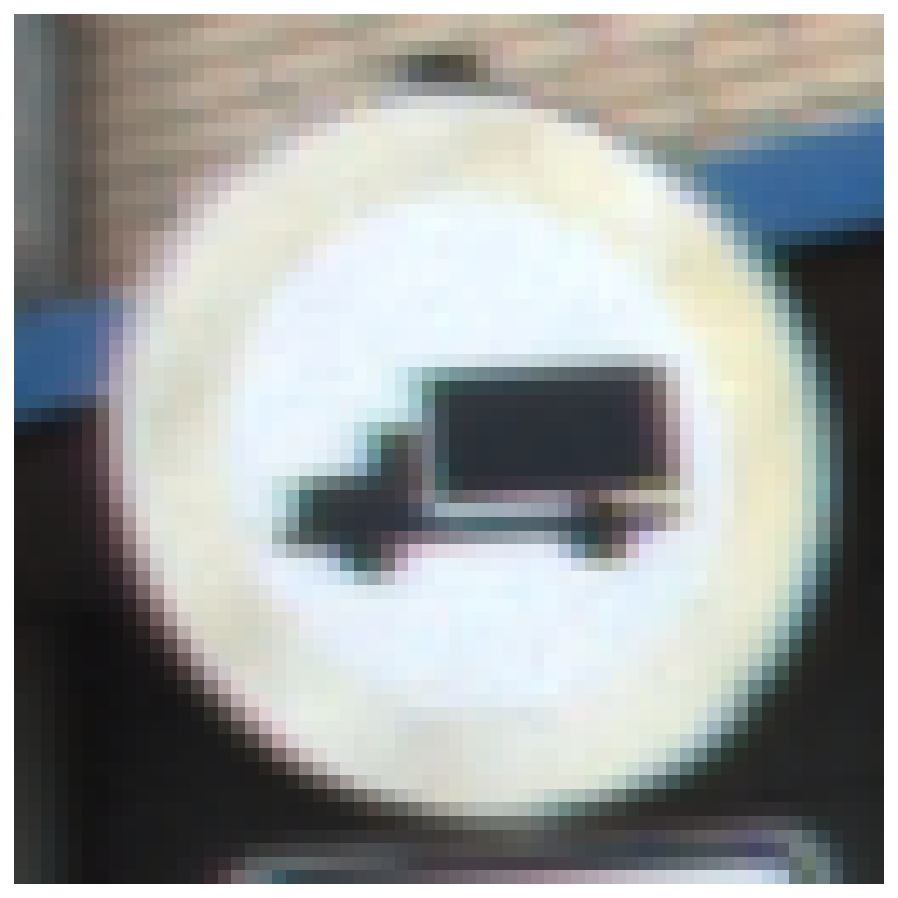

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [ ]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]
'''
class_names = ['00_Speed limit 20km', '01_Speed limit 30km', '02_Speed limit 50km', 
    '03_Speed limit 60km', '04_Speed limit 70km', '05_Speed limit 80km', 
    '06_End of speed limit 80km', '07_Speed limit 100km', 
    '08_Speed limit 120km', '09_No passing', 
    '10_No passing for vehicles over 3.5 metric tons', 
    '11_Right-of-way at the next intersection', '12_Priority road', '13_Yield (give_way)', 
    '14_Stop', '15_No vehicles', '16_Vehicles over 3.5 metric tons prohibited', 
    '17_No entry', '18_General caution', '19_Dangerous curve to the left', 
    '20_Dangerous curve to the right', '21_Double curve', '22_Bumpy road', 
    '23_Slippery road', '24_Road narrows on the right', '24_Road work', 
    '26_Traffic signals', '27_Pedestrians', '28_Children crossing', 
    '29_Bicycles crossing', '30_Beware of ice/snow', '31_Wild animals crossing', 
    '32_End of all speed and passing limits', '33_Turn right ahead', 
    '34_Turn left ahead', '35_Ahead only', '36_Go straight or right', 
    '37_Go straight or left', '38_Keep right', '39_Keep left', '40_Roundabout mandatory', 
    '41_End of no passing', '42_End of no passing by vehicles over 3.5 metric tons']    
'''

class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
'''
class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

#DATASETS = ['train', 'val', 'test']
DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**90% training, 20% validation
 per ogni classe** (Nella corrispettiva cartella)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    #image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    image_paths, indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

00_Speed limit 20km: 210
01_Speed limit 30km: 2220
02_Speed limit 50km: 2250
03_Speed limit 60km: 1410
04_Speed limit 70km: 1980
05_Speed limit 80km: 1860
06_End of speed limit 80km: 420
07_Speed limit 100km: 1440
08_Speed limit 120km: 1410
09_No passing: 1470
10_No passing for vehicles over 3.5 metric tons: 2010
11_Right-of-way at the next intersection: 1320
12_Priority road: 2100
13_Yield (give_way): 2160
14_Stop: 780
15_No vehicles: 630
16_Vehicles over 3.5 metric tons prohibited: 420
17_No entry: 1110
18_General caution: 1200
19_Dangerous curve to the left: 210
20_Dangerous curve to the right: 360
21_Double curve: 330
22_Bumpy road: 390
23_Slippery road: 510
24_Road narrows on the right: 270
24_Road work: 1500
26_Traffic signals: 600
27_Pedestrians: 240
28_Children crossing: 540
29_Bicycles crossing: 270
30_Beware of ice/snow: 450
31_Wild animals crossing: 780
32_End of all speed and passing limits: 240
33_Turn right ahead: 689
34_Turn left ahead: 420
35_Ahead only: 1200
36_Go stra

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [ ]:
from torchvision.transforms.functional import affine
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
'''
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
#!pip install -U albumentations
transform_Albumentation = {'train': A.Compose([
    #A.RandomResizedCrop(size=256),
    T.RandomResizedCrop(size=256),
    #A.Affine(scale=(0.6,1), translate_percent=(0.6), translate_px=None, rotate=(-20,20), shear=(-20,20), interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode=0, fit_output=False, keep_ratio=False, always_apply=False, p=1),
    T.RandomAffine(degrees=(-20, 20), translate=(0.2,0.3), scale=(0.6,1), shear=(-20, 20)),
    T.ColorJitter(brightness=0.7, contrast=0.3, saturation=0.4, hue=0),
    A.Blur(blur_limit=6, always_apply=False, p=0.8),
    A.RandomRain(p=0.8),
    A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=0.5),
    A.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop (size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)          
]), 'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop (size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)           
]),
}
'''

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomAffine(degrees=(-10, 10), translate=(0.43,0.3), scale=(0.6,1), shear=(-20, 20)),
  T.ColorJitter(brightness=0.7, contrast=0.3, saturation=0.4, hue=0), #modifica condizioni foto
  T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #blur
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums),
  T.RandomApply([AddGaussianNoise(0.1, 0.4)], p=0.4)  #rumore sensore
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Cereo dataset PyTorch per ogni "image dataset folder" e "data loaders" per semplificare training


In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Salvo numero di example e nome delle classi in ogni dataset

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

#print('########################################')
print(image_datasets['train'].classes)
#print('########################################')

print(dataset_sizes)

['00_Speed limit 20km', '01_Speed limit 30km', '02_Speed limit 50km', '03_Speed limit 60km', '04_Speed limit 70km', '05_Speed limit 80km', '06_End of speed limit 80km', '07_Speed limit 100km', '08_Speed limit 120km', '09_No passing', '10_No passing for vehicles over 3.5 metric tons', '11_Right-of-way at the next intersection', '12_Priority road', '13_Yield (give_way)', '14_Stop', '15_No vehicles', '16_Vehicles over 3.5 metric tons prohibited', '17_No entry', '18_General caution', '19_Dangerous curve to the left', '20_Dangerous curve to the right', '21_Double curve', '22_Bumpy road', '23_Slippery road', '24_Road narrows on the right', '24_Road work', '26_Traffic signals', '27_Pedestrians', '28_Children crossing', '29_Bicycles crossing', '30_Beware of ice', '31_Wild animals crossing', '32_End of all speed and passing limits', '33_Turn right ahead', '34_Turn left ahead', '35_Ahead only', '36_Go straight or right', '37_Go straight or left', '38_Keep right', '39_Keep left', '40_Roundabout m



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


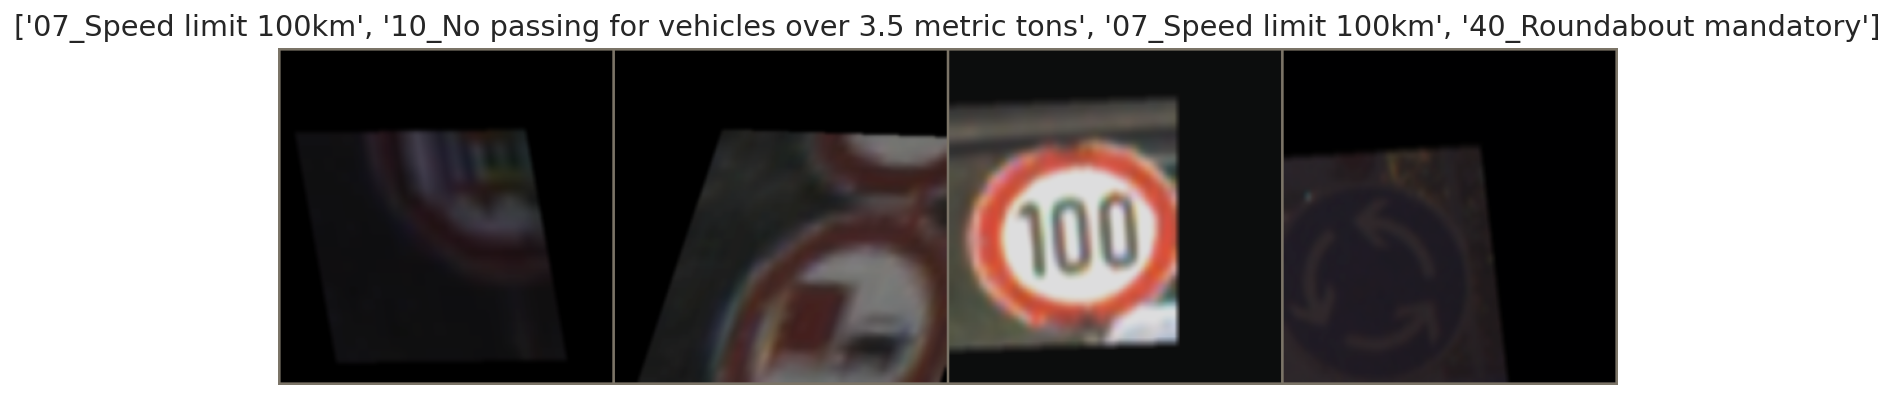

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [ ]:
def create_model(net_model, n_classes):

  if(net_model=='resnet18_no'):
    model = models.resnet18(pretrained = False, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='resnet18'):
    model = models.resnet18(pretrained = True, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if (net_model == 'alexnet'):
    model = models.alexnet(pretrained = True, progress = True)
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(n_features,n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'shufflenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
    model.fc = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True, progress=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [ ]:
                                                                    #30
def train_model(model,net, data_loaders, dataset_sizes, device, n_epochs=10):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  if(net=='resnet18_no'):
    PATH1 = 'drive/MyDrive/Modelli/resnet18_no/resnet18_no.pt' 
    PATH2 = 'drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt'  

  if(net=='resnet18'):
    PATH1 = 'drive/MyDrive/Modelli/resnet18/resnet18.pt'
    PATH2 = 'drive/MyDrive/Modelli/resnet18/resnet18_model.pt'

  if (net == 'alexnet'):
    PATH1 = 'drive/MyDrive/Modelli/alexnet/alexnet.pt'
    PATH2 = 'drive/MyDrive/Modelli/alexnet/alexnet_model.pt'

  if(net == 'googleLeNet'):
    PATH1 = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt'
    PATH2 = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet_model.pt'

  if(net=='mobilenet_v2'):
    PATH1 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2.pt'
    PATH2 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2_model.pt'

  if(net=='mobilenet_v3'):
    PATH1 = 'drive/MyDrive/Modelli/mobilenet_v3/mobilenet_v3.pt'
    PATH2 = 'drive/MyDrive/Modelli/mobilenet_v3/mobilenet_v3_model.pt'

  if(net == 'shufflenet_v2'):
    PATH1 = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.pt'
    PATH2 = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2_model.pt'

  if(net == 'efficientnet_b0'):
    PATH1 = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0.pt'
    PATH2 = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0_model.pt'
   

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      #torch.save(model.state_dict(), 'drive/MyDrive/Modelli/resnet18/resnet18_no.bin')
      torch.save(model.state_dict(), PATH1)
      torch.save(model, PATH2)

      #CARICA INTERO MODELLO
      #model = torch.load(PATH2)
      #model.eval()
      
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  torch.save(model.state_dict(), PATH1)
  print("Model saved")

  
  return model, history

##Resnet18 no pretrain no augmentation

In [ ]:
%%time

base_model = create_model("resnet18_no",len(class_names))

base_model, history = train_model(base_model, 'resnet18_no', data_loaders, dataset_sizes, device)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.5408023095532237  accuracy 0.27959320304778906
Val   loss 1.5822303956595365  accuracy 0.5045906656465188

Epoch 2/10
----------
Train loss 1.146336301075327  accuracy 0.6626709599260369
Val   loss 0.3031874742012571  accuracy 0.9180056108135679

Epoch 3/10
----------
Train loss 0.614821830765556  accuracy 0.827844550004782
Val   loss 0.1528751295300971  accuracy 0.9563886763580719

Epoch 4/10
----------
Train loss 0.38633836836652263  accuracy 0.894506965919597
Val   loss 0.055944326991177115  accuracy 0.9864830400408059

Epoch 5/10
----------
Train loss 0.3584417960257893  accuracy 0.9011700194471897
Val   loss 0.051454340880075056  accuracy 0.9886508543738842

Epoch 6/10
----------
Train loss 0.3399542214609028  accuracy 0.9066534893359262
Val   loss 0.0433739568949947  accuracy 0.9891609283346084

Epoch 7/10
----------
Train loss 0.3227395256416843  accuracy 0.9082475212803264
Val   loss 0.042931078322282545  accuracy 0.988395817393522

Epoch 8/10
----------
Train loss


Scelta e training del modello:

##ResNet18

In [ ]:
%%time
#comando time restituisce wall time della cella
base_model = create_model("resnet18",len(class_names))

base_model, history = train_model(base_model, 'resnet18', data_loaders, dataset_sizes, device)


##AlexNet

In [ ]:
%%time
base_model = create_model('alexnet', len(class_names))


base_model, history = train_model(base_model, 'alexnet', data_loaders, dataset_sizes, device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.2008642335530095  accuracy 0.38534128223929603
Val   loss 0.5816509947133007  accuracy 0.8129303749043612

Epoch 2/10
----------
Train loss 1.3837317164633642  accuracy 0.6124589536774316
Val   loss 0.329464612094619  accuracy 0.9129048712063249

Epoch 3/10
----------
Train loss 1.171468987353491  accuracy 0.6758695444256703
Val   loss 0.17380571676436946  accuracy 0.9535832695740882

Epoch 4/10
----------
Train loss 0.7353055864641097  accuracy 0.7861765549781616
Val   loss 0.02972205031633311  accuracy 0.99171129813823

Epoch 5/10
----------
Train loss 0.6332584671531439  accuracy 0.8139764720885005
Val   loss 0.023556134559399252  accuracy 0.9929864830400408

Epoch 6/10
----------
Train loss 0.5867821613749459  accuracy 0.8231262154493575
Val   loss 0.022191040578950903  accuracy 0.9928589645498597

Epoch 7/10
----------
Train loss 0.5617928840293032  accuracy 0.8324991232824305
Val   loss 0.016799413601928007  accuracy 0.9948992603927569

Epoch 8/10
----------
Train lo

##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, 'googleLeNet', data_loaders, dataset_sizes, device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.5588726561772572  accuracy 0.5781235055950521
Val   loss 0.07305822214041854  accuracy 0.975006375924509

Epoch 2/10
----------
Train loss 0.7285827527574027  accuracy 0.8012242165332992
Val   loss 0.033938423557697814  accuracy 0.9896710022953328

Epoch 3/10
----------
Train loss 0.5745944552359673  accuracy 0.8392259380877992
Val   loss 0.00963054413895484  accuracy 0.9971945932160163

Epoch 4/10
----------
Train loss 0.4498023011837121  accuracy 0.8713935027257945
Val   loss 0.0014067414532877456  accuracy 0.9993624075490946

Epoch 5/10
----------
Train loss 0.417712211107278  accuracy 0.8783753626422672
Val   loss 0.001974899824436726  accuracy 0.9996174445294568

Epoch 6/10
----------
Train loss 0.39796543350472846  accuracy 0.8844645646698759
Val   loss 0.0012037336790890279  accuracy 0.9994899260392757

Epoch 7/10
----------
Train loss 0.38393217313568295  accuracy 0.8882902413364363
Val   loss 0.0013088526943277042  accuracy 0.9997449630196378

Epoch 8/10
---------

##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, 'mobilenet_v2', data_loaders, dataset_sizes, device)

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, 'mobilenet_v3' , data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that exc

Train loss 1.5273837239921637  accuracy 0.5608760799566422
Val   loss 0.11498962844595563  accuracy 0.9645498597296608

Epoch 2/10
----------
Train loss 0.7913436079198428  accuracy 0.7659004686453916
Val   loss 0.10637000718554085  accuracy 0.9667176740627391

Epoch 3/10
----------
Train loss 0.6364991491990497  accuracy 0.8106290050052603
Val   loss 0.02932969353911643  accuracy 0.9901810762560571

Epoch 4/10
----------
Train loss 0.5225502850779468  accuracy 0.8440080339209997
Val   loss 0.014200100928862485  accuracy 0.9952818158633001

Epoch 5/10
----------
Train loss 0.5011285642496582  accuracy 0.8478655912264481
Val   loss 0.010306278708670878  accuracy 0.996684519255292

Epoch 6/10
----------
Train loss 0.4796519174350651  accuracy 0.8560589154206649
Val   loss 0.014163345714938306  accuracy 0.995026778882938

Epoch 7/10
----------
Train loss 0.4738312737503505  accuracy 0.8575254248095131
Val   loss 0.013201919025225066  accuracy 0.9961744452945677

Epoch 8/10
----------
Trai

##ShuffleNet_v2

In [ ]:
%%time
base_model = create_model('shufflenet_v2', len(class_names))


base_model, history = train_model(base_model, 'shufflenet_v2', data_loaders, dataset_sizes, device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 3.4728164914249615  accuracy 0.09583320049733796
Val   loss 2.935476742430283  accuracy 0.2528691660290742

Epoch 2/10
----------
Train loss 2.786698004575263  accuracy 0.24474766474320142
Val   loss 1.7961882125364959  accuracy 0.41851568477429224

Epoch 3/10
----------
Train loss 2.02380453875952  accuracy 0.4128861542385309
Val   loss 1.0172851823964169  accuracy 0.6716398877837286

Epoch 4/10
----------
Train loss 1.6571047848408333  accuracy 0.5264131093187107
Val   loss 0.9027850540334912  accuracy 0.7063249171129814

Epoch 5/10
----------
Train loss 1.5825124996500761  accuracy 0.5452864475404087
Val   loss 0.8346957577724786  accuracy 0.7480234634021933

Epoch 6/10
----------
Train loss 1.5340321835228312  accuracy 0.5621513055121624
Val   loss 0.7308665165472159  accuracy 0.7730170874776843

Epoch 7/10
----------
Train loss 1.4874139765875585  accuracy 0.5757962189562278
Val   loss 0.7320867387020095  accuracy 0.772634532007141

Epoch 8/10
----------
Train loss 1.46

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, 'efficientnet_b0', data_loaders, dataset_sizes, device)

##Visualizzazione History

In [ ]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], 'o-', label='train loss')
  ax1.plot(history['val_loss'], '^-', label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 3.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], 'o-', label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], '^-', label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history shufflenet_v2')
  fig.savefig('drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.png')
  #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

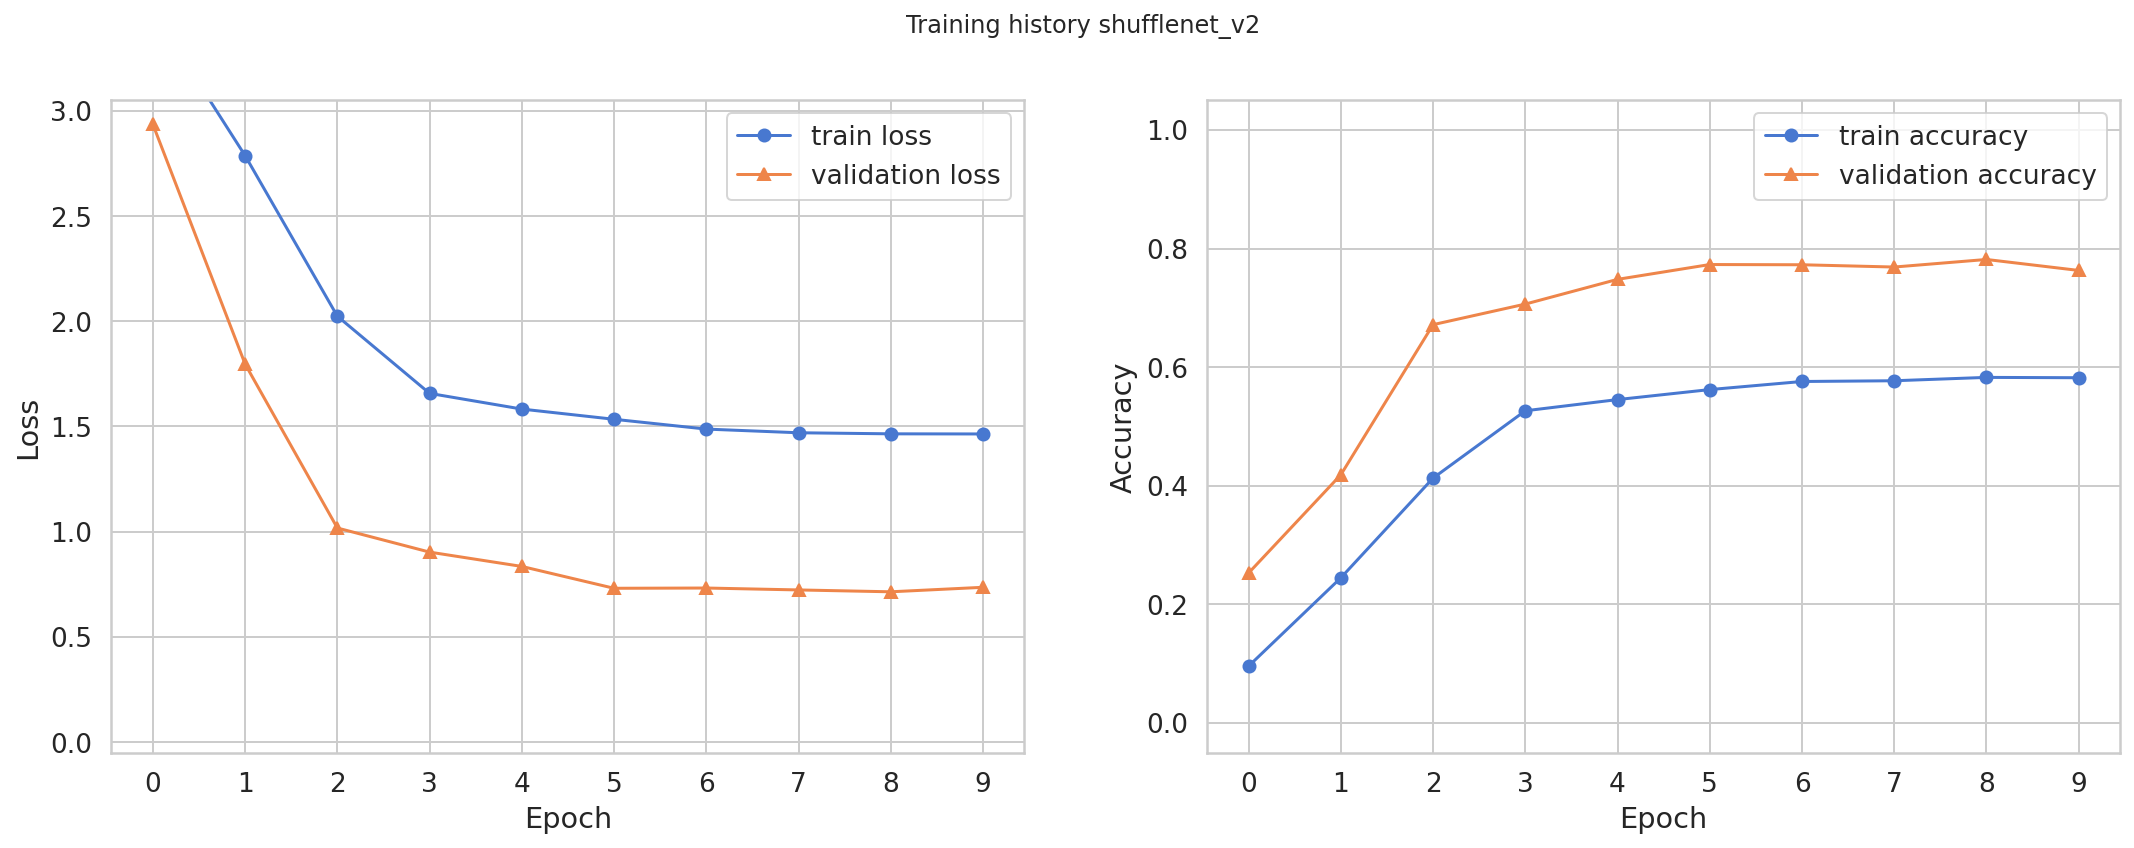

In [ ]:
plot_training_history(history)


## Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
#base_model = create_model('resnet18', 43)

#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli_backup/resnet18_no/resnet18_no.pt', map_location = device))
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_strano.pt', map_location = device))

#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/alexnet/alexnet_no_pretrain_no_augmentation.bin'))

resnet18_no = torch.load('drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt', map_location=device)
resnet18_no.eval() 

base_model = resnet18_no
show_predictions(base_model, class_names, n_images=8)

FileNotFoundError: ignored

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
#print(y_pred, y_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');


cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)
  

##TEST e FPS

In [ ]:
from torchvision.models.resnet import resnet18
import numpy as np
import cv2
import torch
import os
import time
import argparse
import pathlib
import PIL
from PIL import Image
from tqdm import tqdm
#import custom_utils


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GTSRB/Final_Test
!rm -rf GT-final_test.csv
!rm -rf GTSRB/Readme-Images-Final-test.txt
!rm -rf GTSRB/Readme-Images.txt

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -qq GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_GT.zip

#base_model = create_model("resnet18",len(class_names))
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt', map_location = device))     
#base_model.eval()

#resnet18_no = torch.load('drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt', map_location=device)
#resnet18_no.eval() 
#base_model=resnet18_no

#resnet18 = torch.load('drive/MyDrive/Modelli/resnet18/resnet18_model.pt', map_location=device)
#resnet18.eval() 
#base_model = resnet18

#alexnet = torch.load('drive/MyDrive/Modelli/alexnet/alexnet_model.pt', map_location=device)
#alexnet.eval()
#base_model = alexnet

#googleLeNet = torch.load('drive/MyDrive/Modelli/googleLeNet/googleLeNet_model.pt', map_location=device)
#googleLeNet.eval()
#base_model = googleLeNet

#mobilenet_v2 = torch.load('drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2_noRumore_model.pt', map_location=device)
#mobilenet_v2.eval()
#base_model = mobilenet_v2

#mobilenet_v3 = torch.load('drive/MyDrive/Modelli/mobilenet_v3/mobilenet_v3_model.pt', map_location=device)
#mobilenet_v3.eval()
#base_model = mobilenet_v3

#shufflenet_v2 = torch.load('drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2_model.pt', map_location=device)
#shufflenet_v2.eval()
#base_model = shufflenet_v2

efficientnet_b0 = torch.load('drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0_model.pt', map_location=device)
efficientnet_b0.eval()
base_model = efficientnet_b0

# DataFrame for ground truth.
gt_df = pd.read_csv('GT-final_test.csv', delimiter=';' )
gt_df = gt_df.set_index('Filename', drop=True)

a = []
b = []
predictions = []
ground_truth = []
#predictions = torch.FloatTensor(a)
#ground_truth = torch.FloatTensor(b)

counter = 0


correct_count = 0
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second. 
test_images = 0

for filename in tqdm(os.scandir('GTSRB/Final_Test/Images')):
  if filename.is_file():
    #print(filename.path) 
    if(filename.path == 'GTSRB/Final_Test/Images/GT-final_test.test.csv'):
      continue
    
    test_images+=1
 
    #if(test_images==200):
    #  break

    img = Image.open(filename.path)
    img = img.convert('RGB')

    img = transforms['test'](img).unsqueeze(0)

    start_time = time.time()
    pred = base_model(img.to(device)) 
    end_time = time.time()
    # Applica softmax probabilità.
    pred = F.softmax(pred, dim=1)#probs = F.softmax(outputs).data.squeeze()

    _, class_idx = torch.max(pred,1)
    #class_idx = convert(class_idx.item())

    # ground truth.
    image_name = filename.path.split(os.path.sep)[-1]
    gt_idx = gt_df.loc[image_name].ClassId

    if gt_idx == class_idx:
      correct_count += 1
    #else:
    #  print('Sbagliato:')
    #  print('Image_path:',filename.path, 'prediction:',class_idx,'ground_truth:',gt_idx)
    #  print()
    #  print()

    #predictions.append(class_idx)
    #ground_truth.append(gt_idx)
    predictions.append(class_idx)
    ground_truth.append(gt_idx)       
 
    fps = 1 / (end_time - start_time)
    total_fps += fps
    frame_count += 1
predictions = torch.as_tensor(predictions).cpu()
ground_truth = torch.as_tensor(ground_truth).cpu()

print(f"Total number of test images: {test_images}")
print(f"Total correct predictions: {correct_count}")
print(f"Accuracy: {correct_count/test_images*100:.3f}")

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")



--2022-07-19 19:26:21--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  20.6MB/s    in 4.1s    

2022-07-19 19:26:26 (20.6 MB/s) - ‘GTSRB_Final_Test_Images.zip’ saved [88978620/88978620]

--2022-07-19 19:26:26--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   293KB/s    in 0.3s    

12631it [18:04, 11.65it/s]

Total number of test images: 12630
Total correct predictions: 12536
Accuracy: 99.256
Average FPS: 13.006


##Altre Metriche

In [ ]:
print(classification_report(predictions, ground_truth, target_names=class_names))
#print("Accuracy:",accuracy_score(ground_truth, ground_truth, normalize=True, sample_weight=None))
print()

                                                       precision    recall  f1-score   support

                                  00_Speed limit 20km       1.00      1.00      1.00        60
                                  01_Speed limit 30km       1.00      0.99      1.00       724
                                  02_Speed limit 50km       0.99      1.00      1.00       748
                                  03_Speed limit 60km       0.99      0.99      0.99       447
                                  04_Speed limit 70km       0.99      1.00      0.99       657
                                  05_Speed limit 80km       0.99      0.99      0.99       634
                           06_End of speed limit 80km       1.00      1.00      1.00       150
                                 07_Speed limit 100km       1.00      0.99      0.99       454
                                 08_Speed limit 120km       0.99      1.00      0.99       446
                                        09_No pas

## Classificazione immagine non vista


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 88.7MB/s]


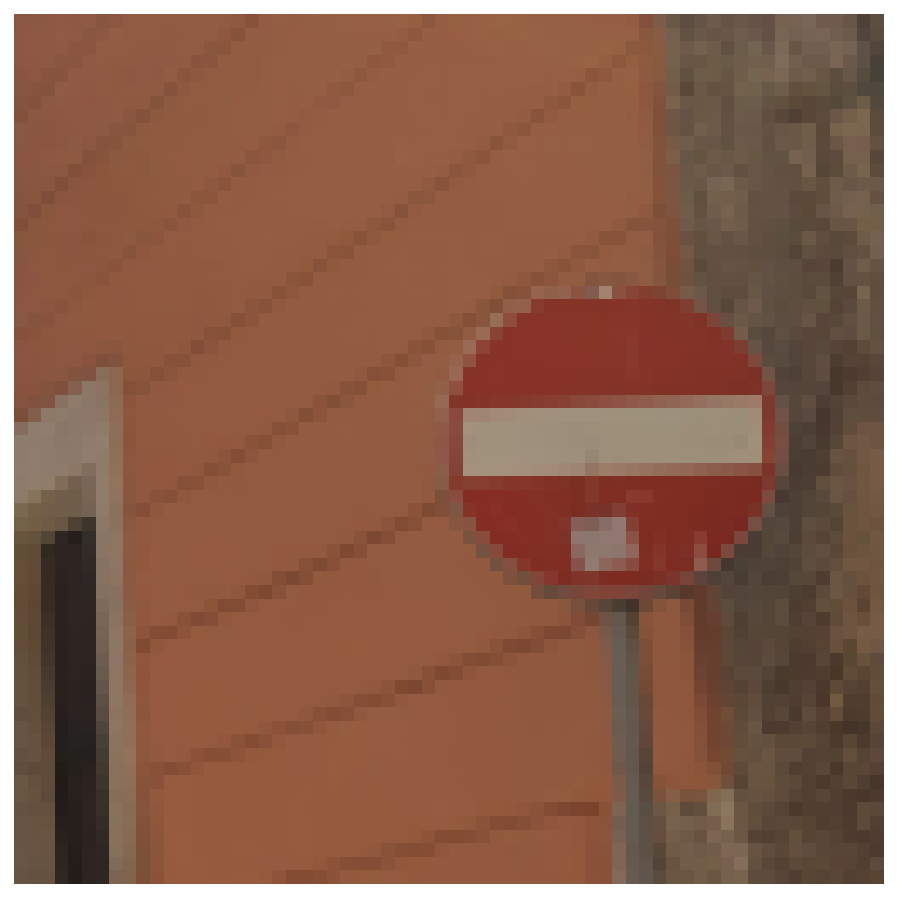

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr


#img_path = 'stop-sign.jpg' #stop
#img_path = 'drive/MyDrive/inference/IMG_20220710_195852_099.jpg' #speed_limit 30
#img_path = 'drive/MyDrive/inference/IMG_20220710_200527.jpg'  #round_about_mandatory
img_path = 'drive/MyDrive/inference/IMG_20220710_193242_762.jpg' #no_entry
#img_path = 'drive/MyDrive/inference/IMG_20220710_195854_666.jpg'  #priority road
#img_path = 'drive/MyDrive/inference/20220710_191336.jpg'  #keep right
#img_path = 'drive/MyDrive/inference/20220710_191319.jpg'   #no entry (rovinatissimo)
show_image(img_path)


Predizione con confidenza rispetto a tutte le classi possibili

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
#base_model = create_model("resnet18_no",len(class_names))
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18_backup/resnet18_strano.pt', map_location = device))     
#base_model.eval()

#resnet18_no = torch.load('drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt', map_location=device)
#resnet18_no.eval() 
#base_model = resnet18_no

#alexnet_rumore = torch.load('drive/MyDrive/Modelli/alexnet/alexnet_rumore_model.pt', map_location=device)
#alexnet_rumore.eval()
#base_model = alexnet_rumore

#alexnet_rumore = torch.load('drive/MyDrive/Modelli/googleLeNet/googleLeNet_model.pt', map_location=device)
#alexnet_rumore.eval()
#base_model = alexnet_rumore

mobilenet_v3 = torch.load('drive/MyDrive/Modelli/mobilenet_v3/mobilenet_v3_model.pt', map_location=device)
mobilenet_v3.eval()
base_model = mobilenet_v3


pred = predict_proba(base_model, img_path)
pred

array([8.8161869e-07, 3.2189496e-06, 2.8219604e-06, 8.0083623e-08,
       4.4484709e-06, 7.2145028e-08, 1.4644157e-08, 2.0121668e-06,
       2.5281465e-06, 4.8405185e-02, 2.0990707e-05, 7.2304590e-07,
       3.2795480e-05, 7.7496188e-06, 3.0419317e-03, 1.4099869e-04,
       3.4033674e-05, 9.4817817e-01, 2.7246966e-05, 4.0532595e-05,
       2.5294113e-07, 1.5791848e-07, 7.4237192e-07, 7.0602619e-06,
       1.1082178e-05, 3.9576634e-07, 1.7980588e-05, 3.4539835e-07,
       9.4806768e-07, 2.3275977e-07, 5.1761624e-08, 1.0722190e-07,
       4.1622307e-06, 3.1161154e-08, 4.2396729e-07, 2.3817003e-07,
       8.4263718e-07, 8.8475281e-07, 9.4592409e-08, 4.5864098e-07,
       6.6941226e-08, 6.8069817e-06, 2.3792234e-07], dtype=float32)

Plot confidenza

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);



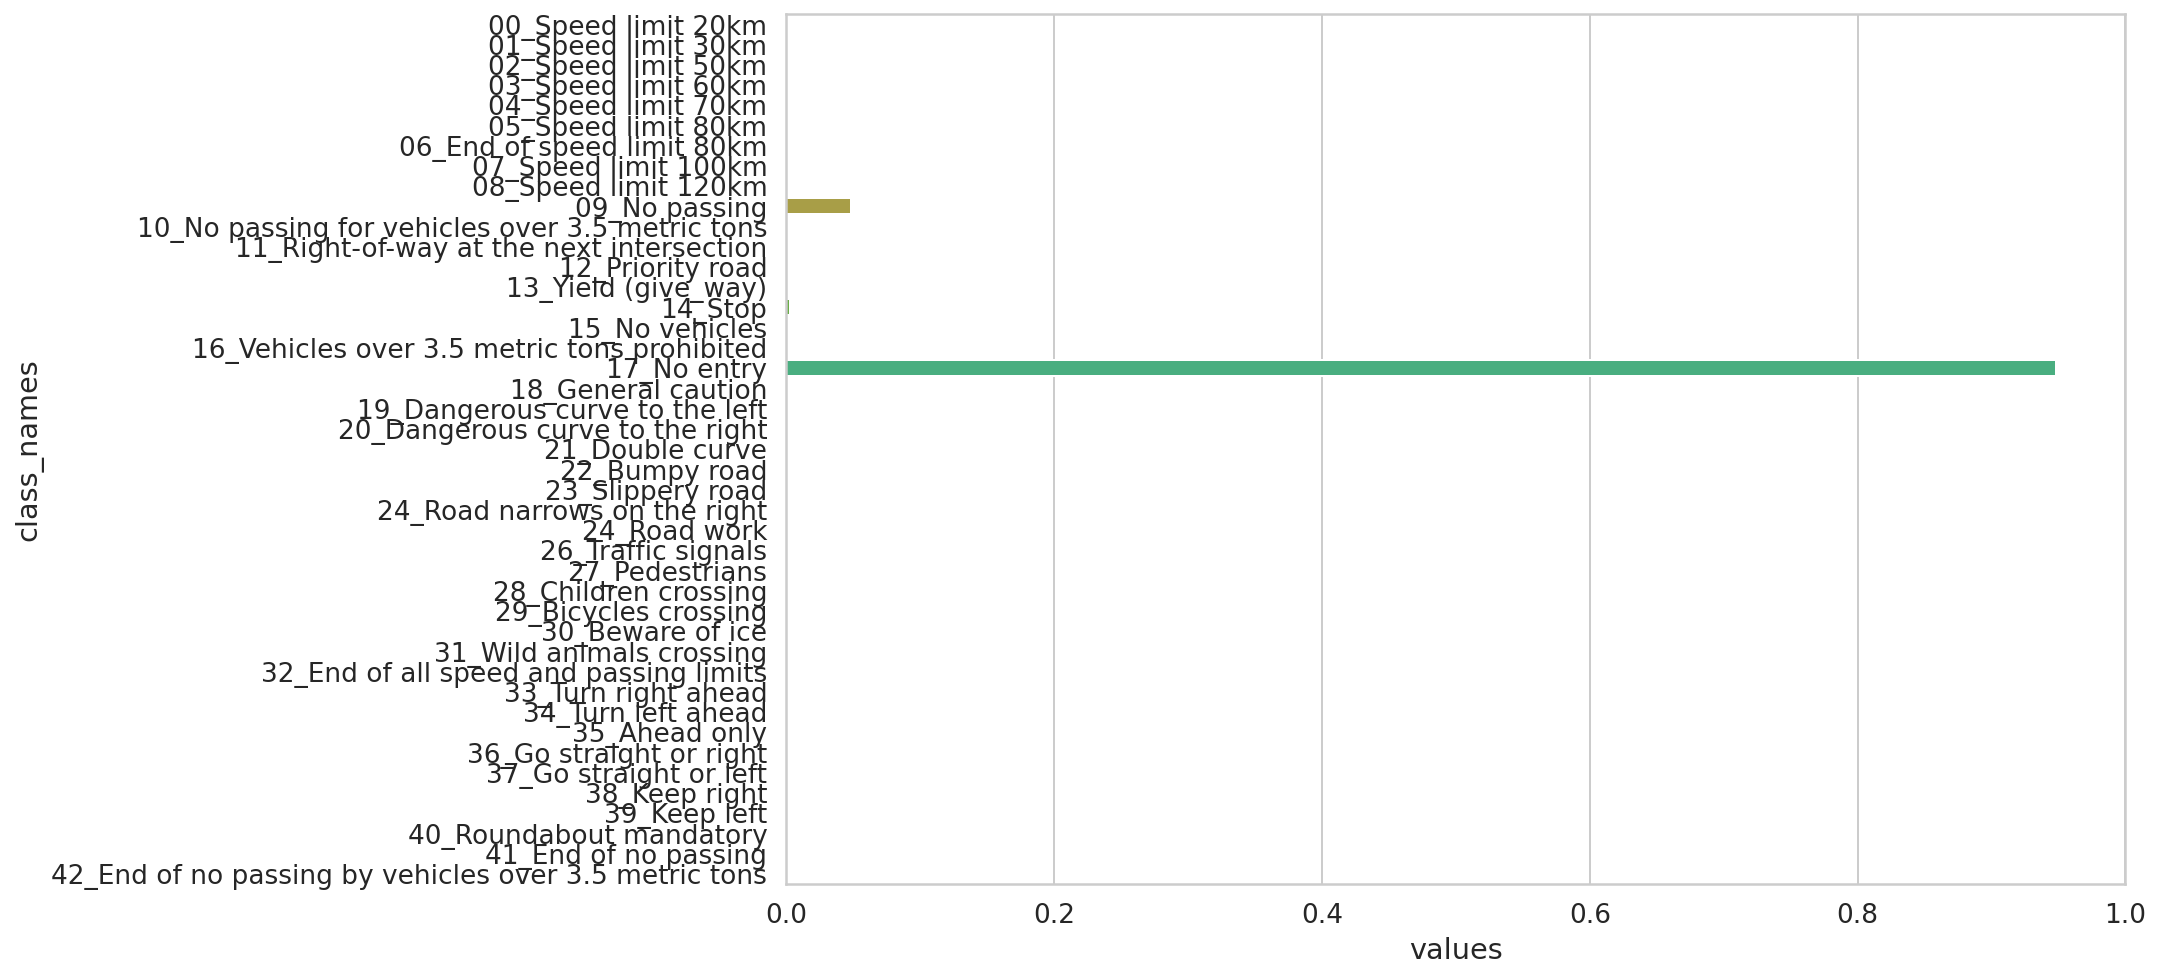

In [ ]:
show_prediction_confidence(pred, class_names)